In [1]:
# Library

import numpy as np
import pandas as pd
import keras
import csv
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, LSTM, Embedding, Bidirectional, Input, Add, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical
from keras import regularizers
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger, LearningRateScheduler
from sklearn.metrics import f1_score, roc_auc_score, recall_score, confusion_matrix
from keras.models import Model
from keras.optimizers import Adam, SGD
from sklearn.model_selection import KFold
from keras.initializers import he_uniform
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

Using TensorFlow backend.


In [2]:
# Read sample from Dataset

with open('fixed_sequences_length_9_PELM/Group_Phos_S_pos.fasta', 'r') as f:
    PELM_s_positif_txt = f.readlines()
with open('fixed_sequences_length_9_PELM/Group_Phos_T_pos.fasta', 'r') as f:
    PELM_t_positif_txt = f.readlines()
with open('fixed_sequences_length_9_PELM/Group_Phos_Y_pos.fasta', 'r') as f:
    PELM_y_positif_txt = f.readlines()
with open('fixed_sequences_length_9_PPA/S_IDS_pos.fasta', 'r') as f:
    PPA_s_positif_txt = f.readlines()
with open('fixed_sequences_length_9_PPA/T_IDS_pos.fasta', 'r') as f:
    PPA_t_positif_txt = f.readlines()
with open('fixed_sequences_length_9_PPA/Y_IDS_pos.fasta', 'r') as f:
    PPA_y_positif_txt = f.readlines()

with open('fixed_sequences_length_9_PELM/Group_Phos_S_neg.fasta', 'r') as f:
    PELM_s_negatif_txt = f.readlines()
with open('fixed_sequences_length_9_PELM/Group_Phos_T_neg.fasta', 'r') as f:
    PELM_t_negatif_txt = f.readlines()
with open('fixed_sequences_length_9_PELM/Group_Phos_Y_neg.fasta', 'r') as f:
    PELM_y_negatif_txt = f.readlines()
with open('fixed_sequences_length_9_PPA/S_IDS_neg.fasta', 'r') as f:
    PPA_s_negatif_txt = f.readlines()
with open('fixed_sequences_length_9_PPA/T_IDS_neg.fasta', 'r') as f:
    PPA_t_negatif_txt = f.readlines()
with open('fixed_sequences_length_9_PPA/Y_IDS_neg.fasta', 'r') as f:
    PPA_y_negatif_txt = f.readlines()

# Pick the window 9

PELM_s_positif = np.array([])
for i in range(1,len(PELM_s_positif_txt),2):
    temp = PELM_s_positif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    PELM_s_positif = np.append(PELM_s_positif, temp2)
print('PELM Dataset, S positive shape: ', PELM_s_positif.reshape(int(len(PELM_s_positif)/9),9).shape)

PELM_t_positif = np.array([])
for i in range(1,len(PELM_t_positif_txt),2):
    temp = PELM_t_positif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    PELM_t_positif = np.append(PELM_t_positif, temp2)
print('PELM Dataset, T positive shape: ', PELM_t_positif.reshape(int(len(PELM_t_positif)/9),9).shape)
    
PELM_y_positif = np.array([])
for i in range(1,len(PELM_y_positif_txt),2):
    temp = PELM_y_positif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    PELM_y_positif = np.append(PELM_y_positif, temp2)
print('PELM Dataset, Y positive shape: ', PELM_y_positif.reshape(int(len(PELM_y_positif)/9),9).shape)

PPA_s_positif = np.array([])
for i in range(1,len(PPA_s_positif_txt),2):
    temp = PPA_s_positif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    PPA_s_positif = np.append(PPA_s_positif, temp2)
print('PPA Dataset, S positive shape: ', PPA_s_positif.reshape(int(len(PPA_s_positif)/9),9).shape)

PPA_t_positif = np.array([])
for i in range(1,len(PPA_t_positif_txt),2):
    temp = PPA_t_positif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    PPA_t_positif = np.append(PPA_t_positif, temp2)
print('PPA Dataset, T positive shape: ', PPA_t_positif.reshape(int(len(PPA_t_positif)/9),9).shape)
    
PPA_y_positif = np.array([])
for i in range(1,len(PPA_y_positif_txt),2):
    temp = PPA_y_positif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    PPA_y_positif = np.append(PPA_y_positif, temp2)
print('PPA Dataset, Y positive shape: ', PPA_y_positif.reshape(int(len(PPA_y_positif)/9),9).shape)

print()

PELM_s_negatif = np.array([])
for i in range(1,len(PELM_s_negatif_txt),2):
    temp = PELM_s_negatif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    PELM_s_negatif = np.append(PELM_s_negatif, temp2)
print('PELM Dataset, S negative shape: ', PELM_s_negatif.reshape(int(len(PELM_s_negatif)/9),9).shape)

PELM_t_negatif = np.array([])
for i in range(1,len(PELM_t_negatif_txt),2):
    temp = PELM_t_negatif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    PELM_t_negatif = np.append(PELM_t_negatif, temp2)
print('PELM Dataset, T negative shape: ', PELM_t_negatif.reshape(int(len(PELM_t_negatif)/9),9).shape)
    
PELM_y_negatif = np.array([])
for i in range(1,len(PELM_y_negatif_txt),2):
    temp = PELM_y_negatif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    PELM_y_negatif = np.append(PELM_y_negatif, temp2)
print('PELM Dataset, Y negative shape: ', PELM_y_negatif.reshape(int(len(PELM_y_negatif)/9),9).shape)

PPA_s_negatif = np.array([])
for i in range(1,len(PPA_s_negatif_txt),2):
    temp = PPA_s_negatif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    PPA_s_negatif = np.append(PPA_s_negatif, temp2)
print('PPA Dataset, S negative shape: ', PPA_s_negatif.reshape(int(len(PPA_s_negatif)/9),9).shape)

PPA_t_negatif = np.array([])
for i in range(1,len(PPA_t_negatif_txt),2):
    temp = PPA_t_negatif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    PPA_t_negatif = np.append(PPA_t_negatif, temp2)
print('PPA Dataset, T negative shape: ', PPA_t_negatif.reshape(int(len(PPA_t_negatif)/9),9).shape)
    
PPA_y_negatif = np.array([])
for i in range(1,len(PPA_y_negatif_txt),2):
    temp = PPA_y_negatif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    PPA_y_negatif = np.append(PPA_y_negatif, temp2)
print('PPA Dataset, Y negative shape: ', PPA_y_negatif.reshape(int(len(PPA_y_negatif)/9),9).shape)


PELM Dataset, S positive shape:  (1554, 9)
PELM Dataset, T positive shape:  (707, 9)
PELM Dataset, Y positive shape:  (267, 9)
PPA Dataset, S positive shape:  (307, 9)
PPA Dataset, T positive shape:  (68, 9)
PPA Dataset, Y positive shape:  (51, 9)

PELM Dataset, S negative shape:  (1543, 9)
PELM Dataset, T negative shape:  (453, 9)
PELM Dataset, Y negative shape:  (226, 9)
PPA Dataset, S negative shape:  (307, 9)
PPA Dataset, T negative shape:  (68, 9)
PPA Dataset, Y negative shape:  (51, 9)


In [3]:
# Choose Dataset to train, make sure correspond with negative dataset

dataset_pos = PELM_s_positif
dataset_neg = PELM_s_negatif
string_name = 'PELM_s'

# Expand dimension, Reshape and Create Label

sequenceLP = int(len(dataset_pos)/9)
dataset_pos = np.expand_dims(dataset_pos, axis=0)
dataset_pos = dataset_pos.reshape(sequenceLP,9)
label_pos = np.ones((sequenceLP,), dtype=int)
label_pos = np.expand_dims(label_pos, axis=0)
label_pos = label_pos.reshape(sequenceLP,1)

sequenceLN = int(len(dataset_neg)/9)
dataset_neg = np.expand_dims(dataset_neg, axis=0)
dataset_neg = dataset_neg.reshape(sequenceLN,9)
label_neg = np.zeros((sequenceLN,), dtype=int)
label_neg = np.expand_dims(label_neg, axis=0)
label_neg = label_neg.reshape(sequenceLN,1)

# Validate

print('Positive Dataset shape: ', dataset_pos.shape)
print('Positive Label shape: ', label_pos.shape)
print('Negative Dataset shape: ', dataset_neg.shape)
print('Negative Label shape: ', label_neg.shape)


Positive Dataset shape:  (1554, 9)
Positive Label shape:  (1554, 1)
Negative Dataset shape:  (1543, 9)
Negative Label shape:  (1543, 1)


In [4]:
# Dataset preparation

dataset_X = np.concatenate((dataset_pos, dataset_neg), axis=0, out=None)
dataset_Y = np.concatenate((label_pos, label_neg), axis=0, out=None)

# Tokenizing, Unique character got its own number

asam = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(asam)
dataset_X_token = []
for i in range(len(dataset_X)):
    temp = tokenizer.texts_to_sequences(dataset_X[i])
    dataset_X_token = np.append(dataset_X_token, temp)

dataset_X_token = dataset_X_token-1
dataset_X_token = dataset_X_token.reshape(len(dataset_X),9)

# Onehot

dataset_X_token_onehot = to_categorical(dataset_X_token)
dataset_X_token_onehot = np.expand_dims(dataset_X_token_onehot, axis=3)
dataset_X_token_onehot = dataset_X_token_onehot.reshape(len(dataset_X),9,20,1)

dataset_Y_onehot = to_categorical(dataset_Y)

# Shuffle Dataset

main_X, main_Y = shuffle(dataset_X_token, dataset_Y_onehot, random_state=13)

# Validation

print('main X shape: ', main_X.shape)
print('main Y shape: ', main_Y.shape)

# Divide into 10 dataset for cross validation

pjg = len(main_X)
A = int(pjg/10)
B = int(pjg/10*2)
C = int(pjg/10*3)
D = int(pjg/10*4)
E = int(pjg/10*5)
F = int(pjg/10*6)
G = int(pjg/10*7)
H = int(pjg/10*8)
I = int(pjg/10*9)

train_X1 = main_X[A:pjg]
train_Y1 = main_Y[A:pjg]
valid_X1 = main_X[0:A]
valid_Y1 = main_Y[0:A]

train_X2 = np.vstack((main_X[0:A], main_X[B:pjg]))
train_Y2 = np.vstack((main_Y[0:A], main_Y[B:pjg]))
valid_X2 = main_X[A:B]
valid_Y2 = main_Y[A:B]

train_X3 = np.vstack((main_X[0:B], main_X[C:pjg]))
train_Y3 = np.vstack((main_Y[0:B], main_Y[C:pjg]))
valid_X3 = main_X[B:C]
valid_Y3 = main_Y[B:C]

train_X4 = np.vstack((main_X[0:C], main_X[D:pjg]))
train_Y4 = np.vstack((main_Y[0:C], main_Y[D:pjg]))
valid_X4 = main_X[C:D]
valid_Y4 = main_Y[C:D]

train_X5 = np.vstack((main_X[0:D], main_X[E:pjg]))
train_Y5 = np.vstack((main_Y[0:D], main_Y[E:pjg]))
valid_X5 = main_X[D:E]
valid_Y5 = main_Y[D:E]

train_X6 = np.vstack((main_X[0:E], main_X[F:pjg]))
train_Y6 = np.vstack((main_Y[0:E], main_Y[F:pjg]))
valid_X6 = main_X[E:F]
valid_Y6 = main_Y[E:F]

train_X7 = np.vstack((main_X[0:F], main_X[G:pjg]))
train_Y7 = np.vstack((main_Y[0:F], main_Y[G:pjg]))
valid_X7 = main_X[F:G]
valid_Y7 = main_Y[F:G]

train_X8 = np.vstack((main_X[0:G], main_X[H:pjg]))
train_Y8 = np.vstack((main_Y[0:G], main_Y[H:pjg]))
valid_X8 = main_X[G:H]
valid_Y8 = main_Y[G:H]

train_X9 = np.vstack((main_X[0:H], main_X[I:pjg]))
train_Y9 = np.vstack((main_Y[0:H], main_Y[I:pjg]))
valid_X9 = main_X[H:I]
valid_Y9 = main_Y[H:I]

train_X10 = main_X[0:I]
train_Y10 = main_Y[0:I]
valid_X10 = main_X[I:pjg]
valid_Y10 = main_Y[I:pjg]

# Validation

print('Training sample shape: ', train_X1.shape)
print('Training label shape: ', train_Y1.shape)
print('Validation sample shape: ', valid_X1.shape)
print('Validation label shape: ', valid_Y1.shape)
print()



main X shape:  (3097, 9)
main Y shape:  (3097, 2)
Training sample shape:  (2788, 9)
Training label shape:  (2788, 2)
Validation sample shape:  (309, 9)
Validation label shape:  (309, 2)



In [5]:
# Neural Network Modeling

epochs = 100

checkpoint1 = ModelCheckpoint('weight_best1.hdf5', monitor='val_loss', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
checkpoint2 = ModelCheckpoint('weight_best2.hdf5', monitor='val_loss', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
checkpoint3 = ModelCheckpoint('weight_best3.hdf5', monitor='val_loss', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
checkpoint4 = ModelCheckpoint('weight_best4.hdf5', monitor='val_loss', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
checkpoint5 = ModelCheckpoint('weight_best5.hdf5', monitor='val_loss', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
checkpoint6 = ModelCheckpoint('weight_best6.hdf5', monitor='val_loss', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
checkpoint7 = ModelCheckpoint('weight_best7.hdf5', monitor='val_loss', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
checkpoint8 = ModelCheckpoint('weight_best8.hdf5', monitor='val_loss', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
checkpoint9 = ModelCheckpoint('weight_best9.hdf5', monitor='val_loss', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
checkpoint10 = ModelCheckpoint('weight_best10.hdf5', monitor='val_loss', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

def scheduler(epoch):
    if epoch > 70:
        return 0.0001
    elif epoch > 40:
        return 0.0002
    elif epoch > 10:
        return 0.0005
    else:
        return 0.001 

lr_schedule= LearningRateScheduler(scheduler)
callback_list1 = [checkpoint1, lr_schedule]
callback_list2 = [checkpoint2, lr_schedule]
callback_list3 = [checkpoint3, lr_schedule]
callback_list4 = [checkpoint4, lr_schedule]
callback_list5 = [checkpoint5, lr_schedule]
callback_list6 = [checkpoint6, lr_schedule]
callback_list7 = [checkpoint7, lr_schedule]
callback_list8 = [checkpoint8, lr_schedule]
callback_list9 = [checkpoint9, lr_schedule]
callback_list10 = [checkpoint10, lr_schedule]

# Input layer

NODES = 13
DROPOUT = 0.1
BIAS = 0.001
KERNEL = 0.001
LR = 0.01

inp = Input(shape=(9,))
x = inp
opt = Adam(lr=LR)

# Hidden layers
x = Embedding(20, 10, input_length=9)(x)
x = Flatten(data_format=None)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='elu', kernel_initializer='he_uniform', bias_regularizer=regularizers.l2(BIAS), kernel_regularizer=regularizers.l2(KERNEL))(x)
x = Dropout(DROPOUT, noise_shape=None, seed=None)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='elu', kernel_initializer='he_uniform', bias_regularizer=regularizers.l2(BIAS), kernel_regularizer=regularizers.l2(KERNEL))(x)
x = Dropout(DROPOUT, noise_shape=None, seed=None)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='elu', kernel_initializer='he_uniform', bias_regularizer=regularizers.l2(BIAS), kernel_regularizer=regularizers.l2(KERNEL))(x)
x = Dropout(DROPOUT, noise_shape=None, seed=None)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='elu', kernel_initializer='he_uniform', bias_regularizer=regularizers.l2(BIAS), kernel_regularizer=regularizers.l2(KERNEL))(x)
x = Dropout(DROPOUT, noise_shape=None, seed=None)(x)
x = BatchNormalization()(x)


output = Dense(2, activation='softmax', bias_regularizer=regularizers.l2(BIAS), kernel_regularizer=regularizers.l2(KERNEL), name='output_layer')(x)

model = Model(inputs=inp, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.save_weights('model.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 9, 10)             200       
_________________________________________________________________
flatten_1 (Flatten)          (None, 90)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 90)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2912      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
__________

In [6]:
# Train The Model

print('Model Train 1')
model_train1 = model.fit(train_X1, train_Y1, epochs=epochs, batch_size=32, 
                        validation_data=(valid_X1, valid_Y1), callbacks=callback_list1)
model.load_weights("model.hdf5")
print('Model Train 2')
model_train2 = model.fit(train_X2, train_Y2, epochs=epochs, batch_size=32, 
                        validation_data=(valid_X2, valid_Y2), callbacks=callback_list2)
model.load_weights("model.hdf5")
print('Model Train 3')
model_train3 = model.fit(train_X3, train_Y3, epochs=epochs, batch_size=32, 
                        validation_data=(valid_X3, valid_Y3), callbacks=callback_list3)
model.load_weights("model.hdf5")
print('Model Train 4')
model_train4 = model.fit(train_X4, train_Y4, epochs=epochs, batch_size=32, 
                        validation_data=(valid_X4, valid_Y4), callbacks=callback_list4)
model.load_weights("model.hdf5")
print('Model Train 5')
model_train5 = model.fit(train_X5, train_Y5, epochs=epochs, batch_size=32, 
                        validation_data=(valid_X5, valid_Y5), callbacks=callback_list5)
model.load_weights("model.hdf5")
print('Model Train 6')
model_train6 = model.fit(train_X6, train_Y6, epochs=epochs, batch_size=32, 
                        validation_data=(valid_X6, valid_Y6), callbacks=callback_list6)
model.load_weights("model.hdf5")
print('Model Train 7')
model_train7 = model.fit(train_X7, train_Y7, epochs=epochs, batch_size=32, 
                        validation_data=(valid_X7, valid_Y7), callbacks=callback_list7)
model.load_weights("model.hdf5")
print('Model Train 8')
model_train8 = model.fit(train_X8, train_Y8, epochs=epochs, batch_size=32, 
                        validation_data=(valid_X8, valid_Y8), callbacks=callback_list8)
model.load_weights("model.hdf5")
print('Model Train 9')
model_train9 = model.fit(train_X9, train_Y9, epochs=epochs, batch_size=32, 
                        validation_data=(valid_X9, valid_Y9), callbacks=callback_list9)
model.load_weights("model.hdf5")
print('Model Train 10')
model_train10 = model.fit(train_X10, train_Y10, epochs=epochs, batch_size=32, 
                        validation_data=(valid_X10, valid_Y10), callbacks=callback_list10)
model.load_weights("model.hdf5")

Model Train 1
Train on 2788 samples, validate on 309 samples
Epoch 1/100
2788/2788 [==============================] - 2s 660us/step - loss: 0.8489 - acc: 0.7457 - val_loss: 0.5193 - val_acc: 0.8964
Epoch 2/100
2788/2788 [==============================] - 1s 202us/step - loss: 0.5664 - acc: 0.8730 - val_loss: 0.4564 - val_acc: 0.9288
Epoch 3/100
2788/2788 [==============================] - 1s 202us/step - loss: 0.5216 - acc: 0.8877 - val_loss: 0.4393 - val_acc: 0.9159
Epoch 4/100
2788/2788 [==============================] - 1s 203us/step - loss: 0.5015 - acc: 0.8913 - val_loss: 0.4221 - val_acc: 0.9320
Epoch 5/100
2788/2788 [==============================] - 1s 202us/step - loss: 0.4793 - acc: 0.9021 - val_loss: 0.4177 - val_acc: 0.9417
Epoch 6/100
2788/2788 [==============================] - 1s 203us/step - loss: 0.4591 - acc: 0.8999 - val_loss: 0.4089 - val_acc: 0.9353
Epoch 7/100
2788/2788 [==============================] - 1s 205us/step - loss: 0.4572 - acc: 0.9028 - val_loss: 0.410

Epoch 60/100
2788/2788 [==============================] - 1s 199us/step - loss: 0.2686 - acc: 0.9344 - val_loss: 0.3148 - val_acc: 0.9450
Epoch 61/100
2788/2788 [==============================] - 1s 198us/step - loss: 0.2673 - acc: 0.9376 - val_loss: 0.3151 - val_acc: 0.9417
Epoch 62/100
2788/2788 [==============================] - 1s 199us/step - loss: 0.2651 - acc: 0.9397 - val_loss: 0.3123 - val_acc: 0.9417
Epoch 63/100
2788/2788 [==============================] - 1s 199us/step - loss: 0.2706 - acc: 0.9344 - val_loss: 0.3130 - val_acc: 0.9353
Epoch 64/100
2788/2788 [==============================] - 1s 198us/step - loss: 0.2614 - acc: 0.9372 - val_loss: 0.3134 - val_acc: 0.9353
Epoch 65/100
2788/2788 [==============================] - 1s 198us/step - loss: 0.2681 - acc: 0.9372 - val_loss: 0.3131 - val_acc: 0.9385
Epoch 66/100
2788/2788 [==============================] - 1s 198us/step - loss: 0.2529 - acc: 0.9433 - val_loss: 0.3114 - val_acc: 0.9417
Epoch 67/100
2788/2788 [==========

Epoch 19/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3800 - acc: 0.9207 - val_loss: 0.4048 - val_acc: 0.9129
Epoch 20/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.3844 - acc: 0.9146 - val_loss: 0.3979 - val_acc: 0.9194
Epoch 21/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.3638 - acc: 0.9211 - val_loss: 0.3949 - val_acc: 0.9161
Epoch 22/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3556 - acc: 0.9236 - val_loss: 0.3897 - val_acc: 0.9161
Epoch 23/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.3472 - acc: 0.9286 - val_loss: 0.3905 - val_acc: 0.9097
Epoch 24/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3591 - acc: 0.9200 - val_loss: 0.3876 - val_acc: 0.9161
Epoch 25/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3673 - acc: 0.9142 - val_loss: 0.3921 - val_acc: 0.9194
Epoch 26/100
2787/2787 [==========

2787/2787 [==============================] - 1s 199us/step - loss: 0.2703 - acc: 0.9336 - val_loss: 0.3374 - val_acc: 0.9161
Epoch 79/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2686 - acc: 0.9365 - val_loss: 0.3379 - val_acc: 0.9161
Epoch 80/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2671 - acc: 0.9376 - val_loss: 0.3366 - val_acc: 0.9161
Epoch 81/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.2646 - acc: 0.9361 - val_loss: 0.3367 - val_acc: 0.9129
Epoch 82/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.2643 - acc: 0.9347 - val_loss: 0.3356 - val_acc: 0.9161
Epoch 83/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.2541 - acc: 0.9376 - val_loss: 0.3367 - val_acc: 0.9129
Epoch 84/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.2757 - acc: 0.9304 - val_loss: 0.3378 - val_acc: 0.9161
Epoch 85/100
2787/2787 [=======================

2787/2787 [==============================] - 1s 199us/step - loss: 0.3292 - acc: 0.9257 - val_loss: 0.3408 - val_acc: 0.9161
Epoch 38/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3131 - acc: 0.9275 - val_loss: 0.3373 - val_acc: 0.9129
Epoch 39/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.3065 - acc: 0.9290 - val_loss: 0.3310 - val_acc: 0.9129
Epoch 40/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3058 - acc: 0.9297 - val_loss: 0.3282 - val_acc: 0.9161
Epoch 41/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2974 - acc: 0.9325 - val_loss: 0.3233 - val_acc: 0.9194
Epoch 42/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3047 - acc: 0.9318 - val_loss: 0.3231 - val_acc: 0.9161
Epoch 43/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3080 - acc: 0.9268 - val_loss: 0.3246 - val_acc: 0.9161
Epoch 44/100
2787/2787 [=======================

2787/2787 [==============================] - 1s 199us/step - loss: 0.2551 - acc: 0.9444 - val_loss: 0.3093 - val_acc: 0.9226
Epoch 97/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2572 - acc: 0.9422 - val_loss: 0.3062 - val_acc: 0.9226
Epoch 98/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2770 - acc: 0.9315 - val_loss: 0.3046 - val_acc: 0.9226
Epoch 99/100
2787/2787 [==============================] - 1s 197us/step - loss: 0.2714 - acc: 0.9340 - val_loss: 0.3052 - val_acc: 0.9258
Epoch 100/100
2787/2787 [==============================] - 1s 197us/step - loss: 0.2525 - acc: 0.9444 - val_loss: 0.3073 - val_acc: 0.9226
Model Train 4
Train on 2788 samples, validate on 309 samples
Epoch 1/100
2788/2788 [==============================] - 1s 197us/step - loss: 0.8322 - acc: 0.7482 - val_loss: 0.5121 - val_acc: 0.8932
Epoch 2/100
2788/2788 [==============================] - 1s 198us/step - loss: 0.5607 - acc: 0.8712 - val_loss: 0.4878 - val

2788/2788 [==============================] - 1s 203us/step - loss: 0.2914 - acc: 0.9293 - val_loss: 0.3266 - val_acc: 0.9223
Epoch 56/100
2788/2788 [==============================] - 1s 199us/step - loss: 0.2725 - acc: 0.9405 - val_loss: 0.3300 - val_acc: 0.9223
Epoch 57/100
2788/2788 [==============================] - 1s 198us/step - loss: 0.2678 - acc: 0.9426 - val_loss: 0.3272 - val_acc: 0.9191
Epoch 58/100
2788/2788 [==============================] - 1s 199us/step - loss: 0.2779 - acc: 0.9336 - val_loss: 0.3271 - val_acc: 0.9159
Epoch 59/100
2788/2788 [==============================] - 1s 198us/step - loss: 0.2757 - acc: 0.9358 - val_loss: 0.3278 - val_acc: 0.9223
Epoch 60/100
2788/2788 [==============================] - 1s 198us/step - loss: 0.2694 - acc: 0.9369 - val_loss: 0.3256 - val_acc: 0.9126
Epoch 61/100
2788/2788 [==============================] - 1s 198us/step - loss: 0.2843 - acc: 0.9279 - val_loss: 0.3236 - val_acc: 0.9191
Epoch 62/100
2788/2788 [=======================

2787/2787 [==============================] - 1s 199us/step - loss: 0.3982 - acc: 0.9150 - val_loss: 0.3892 - val_acc: 0.9194
Epoch 15/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3881 - acc: 0.9157 - val_loss: 0.3846 - val_acc: 0.9290
Epoch 16/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3900 - acc: 0.9146 - val_loss: 0.3805 - val_acc: 0.9194
Epoch 17/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3917 - acc: 0.9157 - val_loss: 0.3798 - val_acc: 0.9258
Epoch 18/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3787 - acc: 0.9186 - val_loss: 0.3732 - val_acc: 0.9097
Epoch 19/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3894 - acc: 0.9139 - val_loss: 0.3650 - val_acc: 0.9258
Epoch 20/100
2787/2787 [==============================] - 1s 197us/step - loss: 0.3787 - acc: 0.9125 - val_loss: 0.3705 - val_acc: 0.9161
Epoch 21/100
2787/2787 [=======================

2787/2787 [==============================] - 1s 203us/step - loss: 0.2720 - acc: 0.9336 - val_loss: 0.3205 - val_acc: 0.9161
Epoch 74/100
2787/2787 [==============================] - 1s 202us/step - loss: 0.2812 - acc: 0.9275 - val_loss: 0.3192 - val_acc: 0.9161
Epoch 75/100
2787/2787 [==============================] - 1s 203us/step - loss: 0.2739 - acc: 0.9343 - val_loss: 0.3190 - val_acc: 0.9129
Epoch 76/100
2787/2787 [==============================] - 1s 206us/step - loss: 0.2741 - acc: 0.9307 - val_loss: 0.3186 - val_acc: 0.9161
Epoch 77/100
2787/2787 [==============================] - 1s 202us/step - loss: 0.2728 - acc: 0.9293 - val_loss: 0.3188 - val_acc: 0.9194
Epoch 78/100
2787/2787 [==============================] - 1s 204us/step - loss: 0.2808 - acc: 0.9275 - val_loss: 0.3203 - val_acc: 0.9194
Epoch 79/100
2787/2787 [==============================] - 1s 202us/step - loss: 0.2660 - acc: 0.9336 - val_loss: 0.3208 - val_acc: 0.9194
Epoch 80/100
2787/2787 [=======================

2787/2787 [==============================] - 1s 198us/step - loss: 0.3356 - acc: 0.9214 - val_loss: 0.3262 - val_acc: 0.9258
Epoch 33/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.3416 - acc: 0.9225 - val_loss: 0.3262 - val_acc: 0.9258
Epoch 34/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3300 - acc: 0.9171 - val_loss: 0.3205 - val_acc: 0.9226
Epoch 35/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.3270 - acc: 0.9247 - val_loss: 0.3146 - val_acc: 0.9226
Epoch 36/100
2787/2787 [==============================] - 1s 197us/step - loss: 0.3156 - acc: 0.9297 - val_loss: 0.3219 - val_acc: 0.9065
Epoch 37/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3171 - acc: 0.9232 - val_loss: 0.3157 - val_acc: 0.9129
Epoch 38/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3134 - acc: 0.9282 - val_loss: 0.3101 - val_acc: 0.9323
Epoch 39/100
2787/2787 [=======================

2787/2787 [==============================] - 1s 199us/step - loss: 0.2512 - acc: 0.9390 - val_loss: 0.2943 - val_acc: 0.9129
Epoch 92/100
2787/2787 [==============================] - 1s 197us/step - loss: 0.2445 - acc: 0.9433 - val_loss: 0.2949 - val_acc: 0.9194
Epoch 93/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2457 - acc: 0.9412 - val_loss: 0.2935 - val_acc: 0.9194
Epoch 94/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2531 - acc: 0.9390 - val_loss: 0.2962 - val_acc: 0.9097
Epoch 95/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2495 - acc: 0.9383 - val_loss: 0.2940 - val_acc: 0.9161
Epoch 96/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2540 - acc: 0.9426 - val_loss: 0.2945 - val_acc: 0.9161
Epoch 97/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2525 - acc: 0.9390 - val_loss: 0.2935 - val_acc: 0.9194
Epoch 98/100
2787/2787 [=======================

2788/2788 [==============================] - 1s 199us/step - loss: 0.2833 - acc: 0.9326 - val_loss: 0.4124 - val_acc: 0.8997
Epoch 51/100
2788/2788 [==============================] - 1s 198us/step - loss: 0.2923 - acc: 0.9333 - val_loss: 0.4075 - val_acc: 0.9029
Epoch 52/100
2788/2788 [==============================] - 1s 199us/step - loss: 0.2729 - acc: 0.9401 - val_loss: 0.4141 - val_acc: 0.8964
Epoch 53/100
2788/2788 [==============================] - 1s 198us/step - loss: 0.2774 - acc: 0.9376 - val_loss: 0.4138 - val_acc: 0.8964
Epoch 54/100
2788/2788 [==============================] - 1s 199us/step - loss: 0.2767 - acc: 0.9369 - val_loss: 0.4201 - val_acc: 0.8964
Epoch 55/100
2788/2788 [==============================] - 1s 197us/step - loss: 0.2827 - acc: 0.9319 - val_loss: 0.4188 - val_acc: 0.8997
Epoch 56/100
2788/2788 [==============================] - 1s 198us/step - loss: 0.2802 - acc: 0.9333 - val_loss: 0.4160 - val_acc: 0.8997
Epoch 57/100
2788/2788 [=======================

2787/2787 [==============================] - 1s 198us/step - loss: 0.4314 - acc: 0.9110 - val_loss: 0.4324 - val_acc: 0.9097
Epoch 10/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.4168 - acc: 0.9182 - val_loss: 0.4277 - val_acc: 0.9097
Epoch 11/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.4097 - acc: 0.9153 - val_loss: 0.4214 - val_acc: 0.9161
Epoch 12/100
2787/2787 [==============================] - 1s 197us/step - loss: 0.4005 - acc: 0.9142 - val_loss: 0.4143 - val_acc: 0.9129
Epoch 13/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3890 - acc: 0.9175 - val_loss: 0.4171 - val_acc: 0.9065
Epoch 14/100
2787/2787 [==============================] - 1s 197us/step - loss: 0.3877 - acc: 0.9168 - val_loss: 0.4136 - val_acc: 0.9129
Epoch 15/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3902 - acc: 0.9146 - val_loss: 0.4115 - val_acc: 0.9097
Epoch 16/100
2787/2787 [=======================

2787/2787 [==============================] - 1s 197us/step - loss: 0.2787 - acc: 0.9318 - val_loss: 0.3467 - val_acc: 0.9129
Epoch 69/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2633 - acc: 0.9365 - val_loss: 0.3482 - val_acc: 0.9161
Epoch 70/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2580 - acc: 0.9351 - val_loss: 0.3489 - val_acc: 0.9097
Epoch 71/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.2534 - acc: 0.9408 - val_loss: 0.3508 - val_acc: 0.9065
Epoch 72/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2675 - acc: 0.9372 - val_loss: 0.3515 - val_acc: 0.9097
Epoch 73/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2544 - acc: 0.9426 - val_loss: 0.3496 - val_acc: 0.9129
Epoch 74/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2580 - acc: 0.9404 - val_loss: 0.3516 - val_acc: 0.9129
Epoch 75/100
2787/2787 [=======================

2787/2787 [==============================] - 1s 199us/step - loss: 0.3516 - acc: 0.9236 - val_loss: 0.3132 - val_acc: 0.9129
Epoch 28/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3604 - acc: 0.9186 - val_loss: 0.3084 - val_acc: 0.9194
Epoch 29/100
2787/2787 [==============================] - 1s 197us/step - loss: 0.3368 - acc: 0.9239 - val_loss: 0.3096 - val_acc: 0.9226
Epoch 30/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3539 - acc: 0.9128 - val_loss: 0.3041 - val_acc: 0.9258
Epoch 31/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.3419 - acc: 0.9221 - val_loss: 0.2993 - val_acc: 0.9226
Epoch 32/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3266 - acc: 0.9272 - val_loss: 0.2977 - val_acc: 0.9290
Epoch 33/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.3164 - acc: 0.9300 - val_loss: 0.2991 - val_acc: 0.9258
Epoch 34/100
2787/2787 [=======================

2787/2787 [==============================] - 1s 198us/step - loss: 0.2613 - acc: 0.9343 - val_loss: 0.2586 - val_acc: 0.9323
Epoch 87/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.2710 - acc: 0.9361 - val_loss: 0.2592 - val_acc: 0.9323
Epoch 88/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2797 - acc: 0.9297 - val_loss: 0.2599 - val_acc: 0.9290
Epoch 89/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.2778 - acc: 0.9376 - val_loss: 0.2599 - val_acc: 0.9323
Epoch 90/100
2787/2787 [==============================] - 1s 197us/step - loss: 0.2686 - acc: 0.9365 - val_loss: 0.2608 - val_acc: 0.9290
Epoch 91/100
2787/2787 [==============================] - 1s 198us/step - loss: 0.2769 - acc: 0.9318 - val_loss: 0.2593 - val_acc: 0.9290
Epoch 92/100
2787/2787 [==============================] - 1s 199us/step - loss: 0.2551 - acc: 0.9401 - val_loss: 0.2598 - val_acc: 0.9323
Epoch 93/100
2787/2787 [=======================

2787/2787 [==============================] - 1s 198us/step - loss: 0.3086 - acc: 0.9282 - val_loss: 0.3276 - val_acc: 0.9194
Epoch 46/100
2787/2787 [==============================] - 1s 205us/step - loss: 0.3085 - acc: 0.9257 - val_loss: 0.3289 - val_acc: 0.9226
Epoch 47/100
2787/2787 [==============================] - 1s 203us/step - loss: 0.2987 - acc: 0.9268 - val_loss: 0.3250 - val_acc: 0.9290
Epoch 48/100
2787/2787 [==============================] - 1s 206us/step - loss: 0.3058 - acc: 0.9318 - val_loss: 0.3296 - val_acc: 0.9258
Epoch 49/100
2787/2787 [==============================] - 1s 205us/step - loss: 0.3029 - acc: 0.9322 - val_loss: 0.3281 - val_acc: 0.9226
Epoch 50/100
2787/2787 [==============================] - 1s 201us/step - loss: 0.2888 - acc: 0.9368 - val_loss: 0.3263 - val_acc: 0.9258
Epoch 51/100
2787/2787 [==============================] - 1s 201us/step - loss: 0.2947 - acc: 0.9304 - val_loss: 0.3248 - val_acc: 0.9258
Epoch 52/100
2787/2787 [=======================

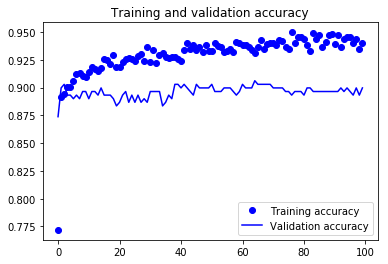

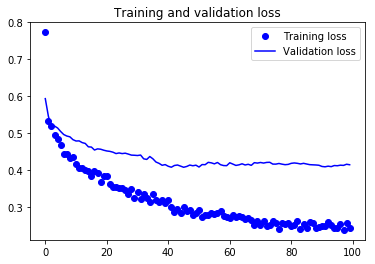

In [7]:
# Plot The Training Accuracy

check = model_train7
accuracy = check.history['acc']
val_accuracy = check.history['val_acc']
loss = check.history['loss']
val_loss = check.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
# Model Score Summary using Cross Validation

model.load_weights("weight_best1.hdf5")
y_pred1 = np.argmax(model.predict(valid_X1), axis=1)
y_true1 = np.argmax(valid_Y1, axis = 1)

model.load_weights("weight_best2.hdf5")
y_pred2 = np.argmax(model.predict(valid_X2), axis=1)
y_true2 = np.argmax(valid_Y2, axis = 1)

model.load_weights("weight_best3.hdf5")
y_pred3 = np.argmax(model.predict(valid_X3), axis=1)
y_true3 = np.argmax(valid_Y3, axis = 1)

model.load_weights("weight_best4.hdf5")
y_pred4 = np.argmax(model.predict(valid_X4), axis=1)
y_true4 = np.argmax(valid_Y4, axis = 1)

model.load_weights("weight_best5.hdf5")
y_pred5 = np.argmax(model.predict(valid_X5), axis=1)
y_true5 = np.argmax(valid_Y5, axis = 1)

model.load_weights("weight_best6.hdf5")
y_pred6 = np.argmax(model.predict(valid_X6), axis=1)
y_true6 = np.argmax(valid_Y6, axis = 1)

model.load_weights("weight_best7.hdf5")
y_pred7 = np.argmax(model.predict(valid_X7), axis=1)
y_true7 = np.argmax(valid_Y7, axis = 1)

model.load_weights("weight_best8.hdf5")
y_pred8 = np.argmax(model.predict(valid_X8), axis=1)
y_true8 = np.argmax(valid_Y8, axis = 1)

model.load_weights("weight_best9.hdf5")
y_pred9 = np.argmax(model.predict(valid_X9), axis=1)
y_true9 = np.argmax(valid_Y9, axis = 1)

model.load_weights("weight_best10.hdf5")
y_pred10 = np.argmax(model.predict(valid_X10), axis=1)
y_true10 = np.argmax(valid_Y10, axis = 1)

def conf_matrix(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1 = f1_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
    auc = roc_auc_score(y_true, y_pred, average='macro', sample_weight=None, max_fpr=None)
    sensi = tp/(tp+fn)
    specificity = tn/(tn+fp)
    accu = (tn + tp)/(tn + tp + fn + fp)
    mcc = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print('{} Result'.format(string_name))
    print('Accuracy :', accu)
    print('AUC :', auc)
    print('Sensitivity :', sensi)
    print('Specificity :', specificity)
    print('F1 :', f1)
    print('MCC :', mcc)
    print()
    return [auc, accu, mcc, f1, sensi, specificity]

auc1, accu1, mcc1, f11, sen1, spec1 = conf_matrix(y_true1, y_pred1)
auc2, accu2, mcc2, f12, sen2, spec2 = conf_matrix(y_true2, y_pred2)
auc3, accu3, mcc3, f13, sen3, spec3 = conf_matrix(y_true3, y_pred3)
auc4, accu4, mcc4, f14, sen4, spec4 = conf_matrix(y_true4, y_pred4)
auc5, accu5, mcc5, f15, sen5, spec5 = conf_matrix(y_true5, y_pred5)
auc6, accu6, mcc6, f16, sen6, spec6 = conf_matrix(y_true6, y_pred6)
auc7, accu7, mcc7, f17, sen7, spec7 = conf_matrix(y_true7, y_pred7)
auc8, accu8, mcc8, f18, sen8, spec8 = conf_matrix(y_true8, y_pred8)
auc9, accu9, mcc9, f19, sen9, spec9 = conf_matrix(y_true9, y_pred9)
auc10, accu10, mcc10, f110, sen10, spec10 = conf_matrix(y_true10, y_pred10)

accu = (accu1 + accu2 + accu3 + accu4 + accu5 + accu6 + accu7 + accu8 + accu9 + accu10)/10
auc = (auc1 + auc2 + auc3 + auc4 + auc5 + auc6 + auc7 + auc8 + auc9 + auc10)/10
f1 = (f11 + f12 + f13 + f14 + f15 + f16 + f17 + f18 + f19 + f110)/10
mcc = (mcc1 + mcc2 + mcc3 + mcc4 + mcc5 + mcc6 + mcc7 + mcc8 + mcc9 + mcc10)/10
sen = (sen1 + sen2 + sen3 + sen4 + sen5 + sen6 + sen7 + sen8 + sen9 + sen10)/10
spec = (spec1 + spec2 + spec3 + spec4 + spec5 + spec6 + spec7 + spec8 + spec9 + spec10)/10

print('{} Result'.format(string_name))
print('Accuracy :', accu)
print('AUC :', auc)
print('Sensitivity :', sen)
print('Specificity :', spec)
print('F1 :', f1)
print('MCC :', mcc)
    
with open('results/summary_{}.csv'.format(string_name), mode='w') as summary_file:
    employee_writer = csv.writer(summary_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    employee_writer.writerow(['Accuracy :', accu])
    employee_writer.writerow(['AUC :', auc])
    employee_writer.writerow(['Sensitivity :', sen])
    employee_writer.writerow(['Specificity :', spec])
    employee_writer.writerow(['F1 :', f1])
    employee_writer.writerow(['MCC :', mcc])

PELM_s Result
Accuracy : 0.948220064724919
AUC : 0.9466341709387345
Sensitivity : 0.9754601226993865
Specificity : 0.9178082191780822
F1 : 0.9520958083832336
MCC : 0.8970457113243496

PELM_s Result
Accuracy : 0.9129032258064517
AUC : 0.9125582944703531
Sensitivity : 0.930379746835443
Specificity : 0.8947368421052632
F1 : 0.9158878504672897
MCC : 0.8260630310790035

PELM_s Result
Accuracy : 0.9193548387096774
AUC : 0.9198842100878837
Sensitivity : 0.89937106918239
Specificity : 0.9403973509933775
F1 : 0.9196141479099678
MCC : 0.8396460266183494

PELM_s Result
Accuracy : 0.919093851132686
AUC : 0.9187405731523379
Sensitivity : 0.9551282051282052
Specificity : 0.8823529411764706
F1 : 0.9226006191950465
MCC : 0.840196069677529

PELM_s Result
Accuracy : 0.9129032258064517
AUC : 0.911484664644422
Sensitivity : 0.8985507246376812
Specificity : 0.9244186046511628
F1 : 0.9018181818181817
MCC : 0.8235767572551157

PELM_s Result
Accuracy : 0.9096774193548387
AUC : 0.9094125973106865
Sensitivity :

In [9]:
# Testing

# print('Model Final')
# model_train = model.fit(main_X, main_Y, epochs=100, batch_size=32, 
#                         validation_data=(test_X, test_Y), callbacks=callback_list)
# model.load_weights("model.hdf5")

In [10]:
# Plot The Training Accuracy

# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
# epochs = range(len(accuracy))
# plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.savefig('results/Acc_result_{}.png'.format(string_name))
# plt.figure()
# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.savefig('results/Loss_result_{}.png'.format(string_name))
# plt.show()

In [11]:
# model.load_weights("weight_best.hdf5")
# y_pred_t = np.argmax(model.predict(test_X), axis=1)
# y_true_t = np.argmax(test_Y, axis = 1)

# def conf_matrix(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     f1 = f1_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
#     auc = roc_auc_score(y_true, y_pred, average='macro', sample_weight=None, max_fpr=None)
#     sensi = tp/(tp+fn)
#     specificity = tn/(tn+fp)
#     accu = (tn + tp)/(tn + tp + fn + fp)
#     mcc = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
#     print('{} Result'.format(string_name))
#     print('Accuracy :', accu)
#     print('AUC :', auc)
#     print('Sensitivity :', sensi)
#     print('Specificity :', specificity)
#     print('F1 :', f1)
#     print('MCC :', mcc)
#     print()
#     return [auc, accu, mcc, f1, sensi, specificity]

# auc_t, accu_t, mcc_t, f1_t, sen_t, spec_t = conf_matrix(y_true_t, y_pred_t)
    
# with open('results/final_summary_{}.csv'.format(string_name), mode='w') as summary_file:
#     employee_writer = csv.writer(summary_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#     employee_writer.writerow(['Accuracy :', accu_t])
#     employee_writer.writerow(['AUC :', auc_t])
#     employee_writer.writerow(['Sensitivity :', sen_t])
#     employee_writer.writerow(['Specificity :', spec_t])
#     employee_writer.writerow(['F1 :', f1_t])
#     employee_writer.writerow(['MCC :', mcc_t])